# `e3nn`从入门到放弃

* 等变要求为[$\mathcal{L}\circ D^{\mathcal{X}}(g) = D^{\mathcal{Y}}(g)\circ \mathcal{L}$](https://arxiv.org/abs/1802.08219)，其中$\mathcal{L}: \mathcal{X}\mapsto \mathcal{Y}$的函数，在等变神经网络实例中为等变的线性层或非线性层。$D^{\mathcal{X}(\mathcal{Y})}(g)$为群元$g\in G$的表示，之所以等号左右两边的$D$的上标不同，是因为等号左边的$D$是作用在输入特征上的，即$X\in\mathcal{X}$，因此该群表示为$\mathcal{X}$空间的维度的群表示，而等号右边为作用在$\mathcal{L}x$的群操作，此时函数$\mathcal{L}$已经将输入特征$x$从$\mathcal{X}$空间映射到$\mathcal{Y}$空间中，维度发生了改变。

In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = "True"

import matplotlib.pyplot as plt

import torch
from torch import nn
from e3nn import o3

## [Irreps](https://docs.e3nn.org/en/latest/guide/irreps.html)

* `e3nn.o3.Irreps('10x0e + 5x1o + 2x2e')`中`10x0e`表示有$10$个$l=0$的偶宇称(`e`)特征，奇宇称为`o`。标量为$l=0$的偶宇称特征，$\because 2l+1=1$，表明维度为1-dim，并且标量不随宇称变化（不会随宇称改变符号）。矢量为$l=1$的奇宇称特征。

torch.Size([35, 35])


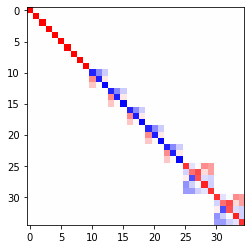

In [2]:
irreps = o3.Irreps("10x0e + 5x1o + 2x2e")

rot = -o3.rand_matrix()

D = irreps.D_from_matrix(rot)
print(D.size())

plt.imshow(D, cmap='bwr', vmin=-1, vmax=1)

* 上面的cell中的代码理解：
  * `irreps = o3.Irreps("10x0e + 5x1o + 2x2e")`确定不可约表示
  * `rot = -o3.rand_matrix()`产生一个随机旋转矩阵。
    * 旋转矩阵
      $$
      \begin{aligned}
      \mathcal{M}(\alpha, \beta, \gamma) &= \mathcal{R}_z(\alpha)\mathcal{R}_x(\beta)\mathcal{R}_z(\gamma)\\
      &=
      \begin{pmatrix}
      \cos\alpha\cos\gamma -\cos\beta\sin\alpha\sin\gamma & -\cos\beta\cos\gamma\sin\alpha - \cos\alpha\sin\gamma & \sin\alpha\sin\beta \\
      \cos\gamma\sin\alpha + \cos\alpha\cos\beta\sin\gamma & \cos\alpha\cos\beta\cos\gamma - \sin\alpha\sin\gamma & -\cos\alpha\sin\beta \\
      \sin\beta\sin\gamma & \cos\gamma\sin\beta & \cos\beta
      \end{pmatrix}
      \end{aligned}
      $$

  * `D = irreps.D_from_matrix(rot)`是对应于旋转矩阵的表示。由于表示为`10x0e + 5x1o + 2x2e`，因此结果为10个标量（$l=0$）、5个$3\times 3$矩阵与2个$5 \times 5$的矩阵的直和。
    * 直和得到的为对角块矩阵。
    * `D.size()`为$(35, 35)$，其中$35=10 * (2 * 0 + 1) + 5 * (2 * 1 + 1) + 2 * (2 * 2 + 1)$。

## [Conv](https://docs.e3nn.org/en/latest/guide/convolution.html)

* [`TFN`](https://arxiv.org/abs/1802.08219)的实现：
  $$
  f_i^\prime = \frac{1}{\sqrt{z}} \sum_{\mathcal{N}_i}f_j\otimes h(\parallel \vec{x}_{ij}\parallel)Y(\frac{\vec{x_{ij}}}{\parallel \vec{x}_{ij}\parallel})
  $$
  其中$f_j$和$f_i^\prime$分别为节点$j$的特征和节点$i$在下一神经网络层的特征，$z$为节点$i$的度, $\mathcal{N}_i$为节点$i$的近邻，$\vec{x}_{ij}$为节点$i$和$j$之间的相对矢量。$h$为MLP，$Y$为球谐函数。$x\otimes (w)y$为$x$和$y$的直积，其中参数为$w$，对应`TFN`的$h(\cdot)$。

In [3]:
from torch_cluster import radius_graph
from torch_scatter import scatter
from e3nn import nn as enn
from e3nn.math import soft_one_hot_linspace


irreps_input = o3.Irreps("10x0e + 10x1e")
irreps_output = o3.Irreps("20x0e + 10x1e")

num_nodes = 100
pos = torch.randn(num_nodes, 3)  # random node positions

# create edges
max_radius = 1.8
edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=num_nodes - 1)

edge_vec = pos[edge_dst] - pos[edge_src]

# compute z
num_neighbors = len(edge_src) / num_nodes

f_in = irreps_input.randn(num_nodes, -1)
print(f_in.size())

irreps_sh = o3.Irreps.spherical_harmonics(lmax=2)
print(irreps_sh)

sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
print(edge_vec.size(), sh.size())

torch.Size([100, 40])
1x0e+1x1o+1x2e
torch.Size([3360, 3]) torch.Size([3360, 9])


* `f_in`为$(100, 40)$的张量，其中100为节点数`num_nodes`，$40=10 * (2 * 0 + 1) + 10 * (2 * 1 + 1)$。
* `o3.Irreps.spherical_harmonics(lmax=2)`表示取球谐函数到$l$最大为2，即取$0, 1, 2$。
* `sh`的第一个维度为`edge_src`的维度，即边的个数；第二个维度$=(2 * 0 + 1) + (2 * 1 + 1) + (2 * 2 + 1)$。

In [4]:
tp = o3.FullyConnectedTensorProduct(irreps_in1=irreps_input, irreps_in2=irreps_sh, irreps_out=irreps_output, shared_weights=False)

print(tp)
print(tp.instructions)
print(o3.FullTensorProduct(irreps_in1=irreps_input, irreps_in2=irreps_sh))

FullyConnectedTensorProduct(10x0e+10x1e x 1x0e+1x1o+1x2e -> 20x0e+10x1e | 400 paths | 400 weights)
[Instruction(i_in1=0, i_in2=0, i_out=0, connection_mode='uvw', has_weight=True, path_weight=0.31622776601683794, path_shape=(10, 1, 20)), Instruction(i_in1=1, i_in2=0, i_out=1, connection_mode='uvw', has_weight=True, path_weight=0.3872983346207417, path_shape=(10, 1, 10)), Instruction(i_in1=1, i_in2=2, i_out=1, connection_mode='uvw', has_weight=True, path_weight=0.3872983346207417, path_shape=(10, 1, 10))]
FullTensorProduct(10x0e+10x1e x 1x0e+1x1o+1x2e -> 10x0o+10x0e+20x1o+20x1e+10x2o+20x2e+10x3e | 100 paths | 0 weights)


* `tp`计算了f_j \otimes (w) Y(\cdot)$，其中`irreps_input`对应着节点$j$的特征的表示，`irreps_sh`对应着球谐函数$Y$。$f_i^\prime$，即输出的维度由`irreps_out`控制。
* `o3.FullyConnectedTensorProduct`实际上是[双线性](https://pytorch.org/docs/stable/generated/torch.nn.Bilinear.html)计算，权重的维度为(output, input$_1$, input$_2$)。在上面的例子中，`irreps_inputs` (input$_1$)为`10x0e+10x1e`，球谐函数`irreps_sh` (input$_2$)为`1x0e+1x1o+1x2e`。暂时先不考虑输出的表示要求，正常的张量积(`o3.FullyTensorProduct`)将会得到
  $$
  \begin{aligned}
    (10\times 0e+10\times 1e) \otimes (1\times 0e+1\times 1o+1\times 2e) &= 10\times 0e \otimes 1\times 0e + 10\times 1e \otimes 1\times 0e + 10\times 0e \otimes 1\times 1o + 10\times 1e \otimes 1\times 1o + 10\times 0e \otimes 1\times 2e + 10\times 1e \otimes 1\times 2e\\
    &=10\times 0e + 10\times 1e + 10\times 1o + 10\times (0\oplus 1 \oplus 2)o + 10\times 2e + 10\times (1\oplus 2\oplus 3)e\\
    &=10\times 0o+10\times 0e+20\times 1o+20\times 1e+10\times 2o+20\times 2e+10\times 3e
  \end{aligned}
  $$
  推导中利用了$e\times e=e, e\times o=o, l_1\otimes l_2=\bigoplus_{l_i=\vert l_1-l_2\vert}^{l_1+l_2}l_i$。而对于`o3.FullyConnectedTensorProduct`相当于只取正常的张量积中对应的部分，并令这部分前的权重为可学习的参数，如果`irreps_output`中包含不在正常的张量积中的项，则其对应的权重数量为0 (e.g. `o3.FullyConnectedTensorProduct(o3.Irreps('10x0e'), o3.Irreps('3x1o'), o3.Irreps('4x0o'))`输出为`FullyConnectedTensorProduct(10x0e x 3x1o -> 4x0o | 0 paths | 0 weights)`，因为$l_1=0$的偶宇称与$l_2=1$的奇宇称的输出只能为$l=1$的奇宇称，可以验证`o3.FullyConnectedTensorProduct(o3.Irreps('10x0e'), o3.Irreps('3x1o'), o3.Irreps('4x1o'))`的输出为`FullyConnectedTensorProduct(10x0e x 3x1o -> 4x1o | 120 paths | 120 weights)`，存在可学习权重)。
* `o3.FullyConnectedTensorProduct`的权重数量计算：
  e.g. 以上面的cell中的输入和输出为例，输入为`10x0e + 10x1e`和`1x0e+1x1o+1x2e`，输出为`20x0e + 10x1e`。其中输出为$20\times 0e$的输入部分只能为$10\times 0e \otimes 1\times 0e$，对应的权重数量为$20\times 10 \times 1=200$ (双线性计算的权重维度)，而$10\times 1e$的输入部分只能为$10\times 1e \otimes 1\times 0e + 10\times 1e \otimes 1\times 2e$，对应的权重数量为$10\times 10 \times 1 + 10 \times 10 \times 1=200$，所以总的权重数量为400 (可通过`tp.instructions`查看，显示的`path_shape`即为这几个路径对应的权重的维度)。

In [5]:
num_basis = 10

edge_length_embedding = soft_one_hot_linspace(
    edge_vec.norm(dim=1),
    start=0.0,
    end=max_radius,
    number=num_basis,
    basis='smooth_finite',
    cutoff=True,
)
edge_length_embedding = edge_length_embedding.mul(num_basis**0.5)

print(edge_vec.size(), edge_length_embedding.size())

fc = enn.FullyConnectedNet([num_basis, 16, tp.weight_numel], torch.relu)
weight = fc(edge_length_embedding)

print(weight.shape)

print('\nParameters of network h:')
for i in fc.parameters():
    print(i.size())

summand = tp(f_in[edge_src], sh, weight)

print('\n', summand.size())

torch.Size([3360, 3]) torch.Size([3360, 10])
torch.Size([3360, 400])

Parameters of network h:
torch.Size([10, 16])
torch.Size([16, 400])

 torch.Size([3360, 50])


* `soft_one_hot_linspace`将每个`x`值根据选取的基组投影$\frac{1}{Z}f_i(x)$。
* 上述操作是为了构建$h(\parallel \vec{x_{ij}} \parallel)$：$h(\cdot)$将原子间距映射为双线性计算中张量积的系数。为了构建该系数，首先利用原子间距产生维度为(边的个数, 基组数量)的特征作为网络的输入。
* `o3.nn.FullyConnectedNet`接受一个列表作为参数，类似于`torch.nn.Sequential`构建一个多层神经网络网络。网络的输入维度应等于基组的数量，输出应等于`tp`的所需的权重的维度。
* `tp(f_in[edge_src], sh, weight)`计算了$x\otimes (w)y$。

In [6]:
f_out = scatter(summand, edge_dst, dim=0, dim_size=num_nodes).div(num_neighbors ** 0.5)

print(f_out.size())

torch.Size([100, 50])


![](https://raw.githubusercontent.com/rusty1s/pytorch_scatter/master/docs/source/_figures/add.svg?sanitize=true)
* `torch_scatter.scatter`第一个参数为输入的特征，第二个参数为指标，以一维张量为例，`scatter`函数将根据指标将相同的指标所对应的输入特征进行约化聚合。因此`f_out`是根据`edge_dst`将相同指标的`summand`聚合 (相同指标的`edge_dst`代表着对应的`edge_src`指向相同的目标节点，因此这些源节点为该目标节点$i$的近邻$\mathcal{N}_i$)。
* `.div(num_neighbors ** 0.5)`计算了$\frac{1}{\sqrt{z}}$。

In [7]:
def check_equiv(irreps_input, irreps_output, model, **kwargs):
    rot = o3.rand_matrix()
    D_in = irreps_input.D_from_matrix(rot)
    D_out = irreps_output.D_from_matrix(rot)

    f_bef = model(kwargs['f_in']@D_in.T, kwargs['pos']@rot.T)
    f_aft = model(kwargs['f_in'], kwargs['pos'])@D_out.T
    return torch.allclose(f_bef, f_aft)

* 检查等变性$\mathcal{L}\circ D^{\mathcal{X}}(g) = D^{\mathcal{Y}}(g)\circ \mathcal{L}$

* `e3nn.math.soft_unit_step`是一个阶跃函数。具体形式为$x\mapsto \theta(x)e^{-1/x}$。当$x>0$，该函数等价于$e^{-1/x}$，但当$x$取值存在0时，会将小于等于0的部分全部置0。

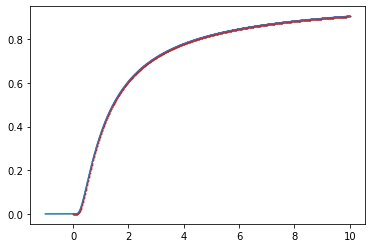

In [8]:
from e3nn.math import soft_unit_step

x = torch.linspace(-1.0, 10.0, 1000)
plt.plot(x, soft_unit_step(x))

x1 = torch.linspace(0.00001, 10.0, 1000)
plt.scatter(x1, torch.exp(-1 / x1), s=0.5, c='r')